In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
import tqdm as tqdm
import itertools

from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision.transforms import functional as F

from matplotlib import pyplot as plt
import scipy.io as sio

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
DIR_INPUT = 'data'
DIR_TRAIN_IMG = f'{DIR_INPUT}/WIDER_train/images'
DIR_TRAIN_LABELS = f'{DIR_INPUT}/wider_face_split'

In [4]:
wider_raw = sio.loadmat(f'{DIR_TRAIN_LABELS}/wider_face_train.mat')

In [5]:
wider_raw.keys()

dict_keys(['__header__', '__version__', '__globals__', 'blur_label_list', 'event_list', 'expression_label_list', 'face_bbx_list', 'file_list', 'illumination_label_list', 'invalid_label_list', 'occlusion_label_list', 'pose_label_list'])

In [6]:
wider_raw['occlusion_label_list'][0][0][20][0]

array([[1],
       [0]], dtype=uint8)

In [7]:
def imshow(img, bboxes=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img, aspect='equal')
    
    if bboxes is not None:
        for bbox in bboxes:
            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='red', linewidth=3.5)
                )

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

In [8]:
wider_img_list = []
wider_bboxes = []
event_list = wider_raw.get('event_list')
file_list = wider_raw.get('file_list')
face_bbx_list = wider_raw.get('face_bbx_list')
img_count=0
for event_idx, event in enumerate(event_list):
    directory = event[0][0]
    for im_idx, im in enumerate(file_list[event_idx][0]):
        im_name = im[0][0]
        face_bbx = face_bbx_list[event_idx][0][im_idx][0]
        #  print face_bbx.shape
        
        bboxes = []

        for i in range(face_bbx.shape[0]):
            xmin = int(face_bbx[i][0])
            ymin = int(face_bbx[i][1])
            xmax = int(face_bbx[i][2]) + xmin
            ymax = int(face_bbx[i][3]) + ymin
            if xmin != 0 and ymin != 0 and xmax != 0 and ymax != 0:
                bboxes.append((xmin, ymin, xmax, ymax))

        image_name =os.path.join(DIR_TRAIN_IMG, directory,
                   im_name + '.jpg')
#         print(im_name)
        wider_img_list.append(image_name)
        wider_bboxes.append(bboxes)
        
#         imshow(im, bboxes)
        
        if img_count >= 110: break
        img_count += 1
    if img_count >= 110: break

In [9]:
class WiderDataset(object):
    """
    Build a wider parser
    Parameters
    ----------
    image_list : path of the label file
    bboxes_list : path of the image files
    transforms : Any pytorch transforms needs to be performed
    Returns
    -------
    a wider parser
    """
    def __init__(self, image_list, bboxes_list, transforms=None):

        self.transforms = transforms
        self.image_list = image_list
        self.bboxes_list = bboxes_list


    def __getitem__(self, idx):

        image_name = self.image_list[idx]
        boxes = self.bboxes_list[idx]

        im = cv2.imread(image_name, cv2.IMREAD_COLOR)
        im = im[:, :, (2, 1, 0)]
        im = im.astype(np.float32)
        im /= 255.0
        
#         im = F.to_tensor(im)

        num_objs = len(boxes)

#         imshow(im, boxes)

    
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
#         imshow(im, boxes)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            im, target = self.transforms(im, target)

        return im, target

    def __len__(self):
        return len(self.image_list)


In [10]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
class EvaluationAverager:
    def __init__(self):
        self.prec = []
        self.rec = []
        self.mpre = []
        self.mrec = []
        self.count_face = 0
        self.TP_sum = 0
        self.FP_sum = 0
        
        self.ap_ = 0
        self.iterations_ = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
dataset = WiderDataset(wider_img_list[:40], wider_bboxes[:40])
test_dataset = WiderDataset(wider_img_list[40:], wider_bboxes[40:])
train_loader = DataLoader(dataset,
    batch_size=3,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)
test_loader = DataLoader(dataset,
    batch_size=3,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', True)
for param in backbone.parameters():
    param.requires_grad = False
model.backbone = backbone

In [16]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [17]:
itera = iter(train_loader)

images, targets = next(itera)
images = list(F.to_tensor(image) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

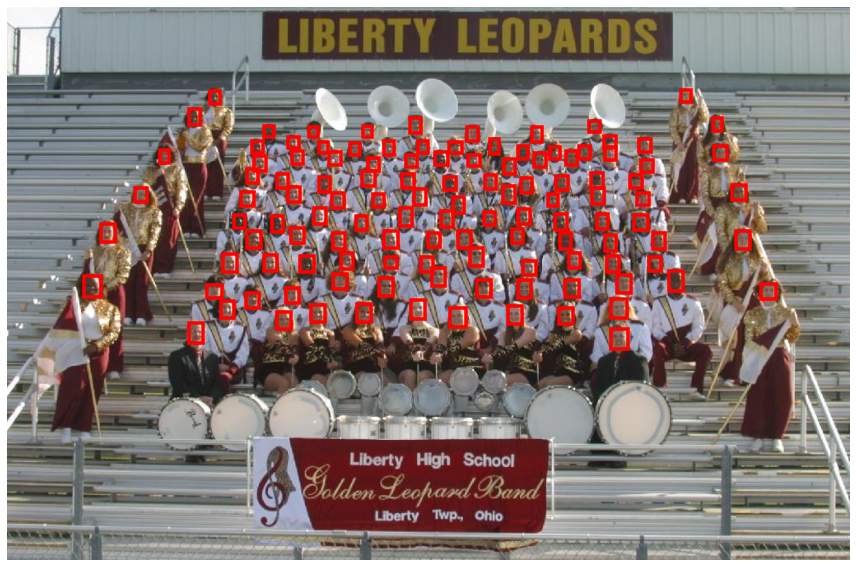

In [18]:
imshow(np.moveaxis(images[0].numpy(),0,-1),targets[0]['boxes'])

In [19]:
%%time
model.train()
loss_dict = model(images, targets)

CPU times: user 13.4 s, sys: 3.03 s, total: 16.4 s
Wall time: 12.6 s


In [20]:
%%time
model.eval()
with torch.no_grad():
    prediction = model(images)

CPU times: user 11.7 s, sys: 2.09 s, total: 13.8 s
Wall time: 12.1 s


In [21]:
boxes = prediction[0]['boxes'][prediction[0]['scores']>0.3]

In [22]:
images[0].shape

torch.Size([3, 672, 1024])

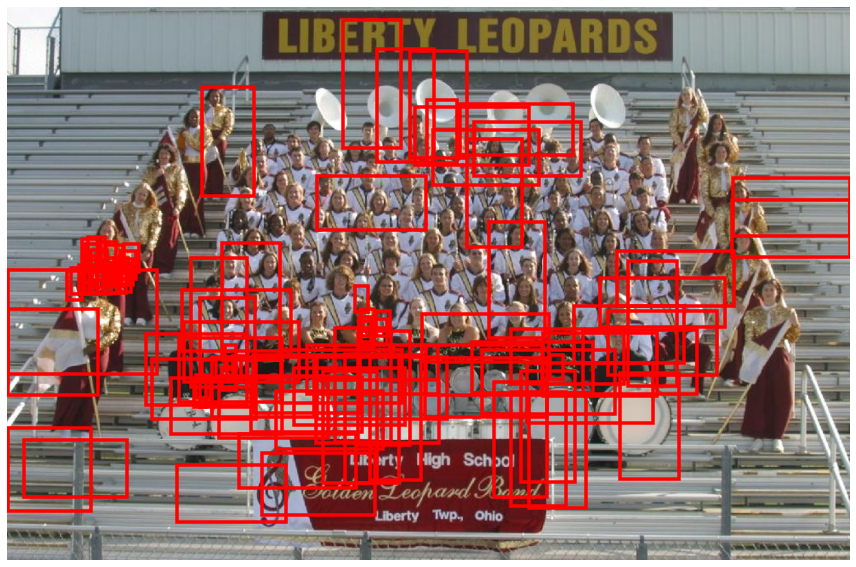

In [23]:
imshow(np.moveaxis(images[0].numpy(),0,-1),prediction[0]['boxes'])

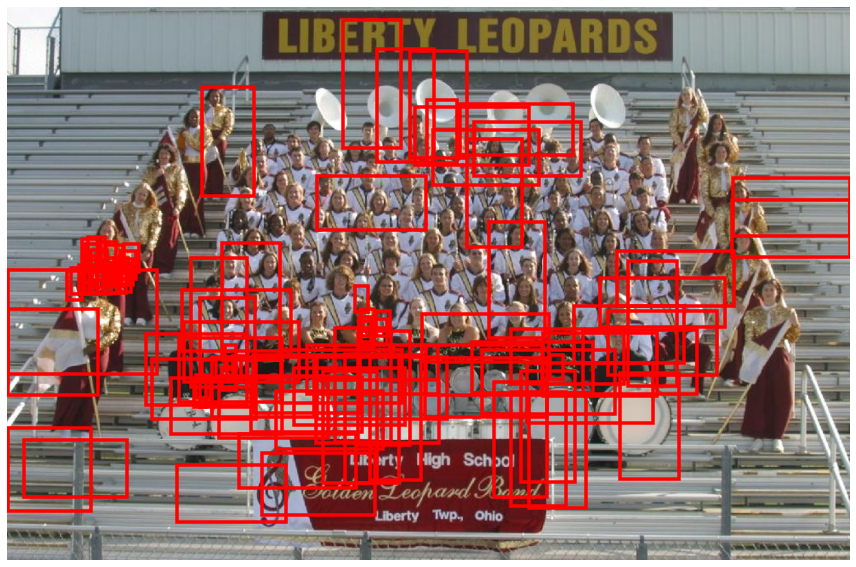

In [24]:
imshow(np.moveaxis(images[0].numpy(),0,-1),boxes)

In [25]:
loss_dict

{'loss_classifier': tensor(0.7086, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1121, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.7763, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.4612, grad_fn=<DivBackward0>)}

In [26]:
loss_dict

{'loss_classifier': tensor(0.7086, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1121, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.7763, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.4612, grad_fn=<DivBackward0>)}

In [27]:
loss_dict['loss_classifier'].grad_fn.next_functions[0][0]

In [28]:
losses = sum(loss for loss in loss_dict.values())
print(losses)

tensor(2.0581, grad_fn=<AddBackward0>)


In [29]:
loss_value = losses.item()
loss_value

2.058117151260376

In [30]:
optimizer.zero_grad()

NameError: name 'optimizer' is not defined

In [31]:
losses.backward()

In [32]:
for x in model.roi_heads.box_predictor.parameters():
    print(x)

Parameter containing:
tensor([[-0.0250, -0.0219, -0.0281,  ..., -0.0085, -0.0292, -0.0307],
        [ 0.0219, -0.0301,  0.0122,  ...,  0.0219,  0.0103, -0.0184]],
       requires_grad=True)
Parameter containing:
tensor([0.0257, 0.0075], requires_grad=True)
Parameter containing:
tensor([[-0.0272,  0.0310,  0.0041,  ...,  0.0140,  0.0275,  0.0113],
        [ 0.0305,  0.0220, -0.0087,  ..., -0.0009,  0.0045, -0.0087],
        [ 0.0196, -0.0045, -0.0174,  ..., -0.0131,  0.0152, -0.0155],
        ...,
        [-0.0185, -0.0220, -0.0133,  ..., -0.0150,  0.0282,  0.0153],
        [-0.0223,  0.0072, -0.0310,  ..., -0.0151, -0.0204,  0.0223],
        [-0.0145, -0.0159, -0.0229,  ..., -0.0263,  0.0148,  0.0029]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0042,  0.0146,  0.0048, -0.0047,  0.0045,  0.0009,  0.0239,  0.0272],
       requires_grad=True)


In [33]:
optimizer.step()

NameError: name 'optimizer' is not defined

In [34]:
for x in model.roi_heads.box_predictor.parameters():
    print(x)

Parameter containing:
tensor([[-0.0250, -0.0219, -0.0281,  ..., -0.0085, -0.0292, -0.0307],
        [ 0.0219, -0.0301,  0.0122,  ...,  0.0219,  0.0103, -0.0184]],
       requires_grad=True)
Parameter containing:
tensor([0.0257, 0.0075], requires_grad=True)
Parameter containing:
tensor([[-0.0272,  0.0310,  0.0041,  ...,  0.0140,  0.0275,  0.0113],
        [ 0.0305,  0.0220, -0.0087,  ..., -0.0009,  0.0045, -0.0087],
        [ 0.0196, -0.0045, -0.0174,  ..., -0.0131,  0.0152, -0.0155],
        ...,
        [-0.0185, -0.0220, -0.0133,  ..., -0.0150,  0.0282,  0.0153],
        [-0.0223,  0.0072, -0.0310,  ..., -0.0151, -0.0204,  0.0223],
        [-0.0145, -0.0159, -0.0229,  ..., -0.0263,  0.0148,  0.0029]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0042,  0.0146,  0.0048, -0.0047,  0.0045,  0.0009,  0.0239,  0.0272],
       requires_grad=True)


In [35]:
for x in model.roi_heads.box_predictor.parameters():
    print(x.grad)

tensor([[-1.2290e-02, -9.1317e-02, -1.0589e-01,  ..., -5.1278e-05,
         -1.5583e-01, -5.8822e-02],
        [ 1.2290e-02,  9.1317e-02,  1.0589e-01,  ...,  5.1278e-05,
          1.5583e-01,  5.8822e-02]])
tensor([-0.3760,  0.3760])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0010,  0.0242,  0.0483,  ...,  0.0000,  0.0607,  0.0133],
        [ 0.0005,  0.0203,  0.0425,  ...,  0.0000,  0.0526,  0.0099],
        [-0.0004, -0.0122, -0.0274,  ...,  0.0000, -0.0323, -0.0066]])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.1138,  0.1164,  0.1009, -0.0618])


In [36]:
# model(images, targets)

In [37]:
piter = iter(model.parameters())

In [38]:
piter = iter(model.rpn.named_parameters())


In [39]:
for i in model.rpn.named_modules():
    print(i)

('', RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
))
('anchor_generator', AnchorGenerator())
('head', RPNHead(
  (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
))
('head.conv', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('head.cls_logits', Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)))
('head.bbox_pred', Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1)))


## Train

In [49]:
train_dataset = WiderDataset(wider_img_list[:100], wider_bboxes[:100])
test_dataset = WiderDataset(wider_img_list[100:], wider_bboxes[100:])
train_loader = DataLoader(train_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)
test_loader = DataLoader(test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

In [50]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [54]:
backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', True)
for param in backbone.parameters():
    param.requires_grad = False
model.backbone = backbone

In [55]:
# model.load_state_dict(torch.load('fasterrcnn_resnet18_fpn.pth'))

In [56]:
# %%time
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 3

In [57]:
len(params)

14

In [47]:
%%time
start = time.time()
loss_hist = Averager()
itr = 1

# model.train()
for epoch in range(num_epochs):
    loss_hist.reset()
#     print(epoch)
    for images, targets in train_loader:
        
        images = list(F.to_tensor(image) for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
#         print(loss_dict)
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

end = time.time()
print(f"Time elapsed: {(end-start)/60:.2f}")

Iteration #10 loss: 1.8543379306793213
Iteration #20 loss: 1.4250507354736328
Iteration #30 loss: 1.433602213859558
Epoch #0 loss: 1.345531875596327
Iteration #40 loss: 1.3280240297317505
Iteration #50 loss: 1.2479389905929565
Iteration #60 loss: 1.0784883499145508
Epoch #1 loss: 1.1030090801856096
Iteration #70 loss: 0.9852455854415894
Iteration #80 loss: 1.0239253044128418
Iteration #90 loss: 1.0470070838928223
Iteration #100 loss: 0.9081190228462219
Epoch #2 loss: 1.096160261946566
Time elapsed: 38.75
CPU times: user 38min 53s, sys: 7min 59s, total: 46min 53s
Wall time: 38min 44s


In [60]:
%%time
start = time.time()
loss_hist = Averager()
itr = 1

# model.train()
for epoch in range(num_epochs):
    loss_hist.reset()
#     print(epoch)
    for images, targets in train_loader:
        
        images = list(F.to_tensor(image) for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
#         print(loss_dict)
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

end = time.time()
print(f"Time elapsed: {(end-start)/60:.2f}")

Iteration #10 loss: 1.6315157413482666
Iteration #20 loss: 1.196797490119934
Iteration #30 loss: 1.749987244606018
Epoch #0 loss: 1.3050222729935366
Iteration #40 loss: 1.5706055164337158
Iteration #50 loss: 1.2701858282089233
Iteration #60 loss: 1.5898736715316772
Epoch #1 loss: 1.3543359146398657
Iteration #70 loss: 1.158257246017456
Iteration #80 loss: 1.0446208715438843
Iteration #90 loss: 1.2077360153198242
Iteration #100 loss: 0.8716849684715271
Epoch #2 loss: 1.1971430235049303
Iteration #110 loss: 1.2406636476516724
Iteration #120 loss: 1.2339118719100952
Iteration #130 loss: 0.9812923073768616
Epoch #3 loss: 1.1064544653191286
Iteration #140 loss: 0.8263031840324402
Iteration #150 loss: 0.7563209533691406
Iteration #160 loss: 1.0007994174957275
Iteration #170 loss: 0.19008053839206696
Epoch #4 loss: 1.0398942043676096
Iteration #180 loss: 0.6488201022148132
Iteration #190 loss: 1.022823452949524
Iteration #200 loss: 0.8844420313835144
Epoch #5 loss: 0.9815606878084295
Iteratio

In [61]:
torch.save(model.state_dict(), 'fasterrcnn_resnet18_fpn3.pth')

In [63]:
model.load_state_dict(torch.load('fasterrcnn_resnet18_fpn3.pth'))

<All keys matched successfully>

In [65]:
%%time
start = time.time()

prediction_info = []
target_info = []
model.eval()

for images, targets in test_loader:

    images = list(F.to_tensor(image) for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)
    prediction_info.append(predictions)
    target_info.append(targets)
#     print(len(predictions[0]['scores']))

end = time.time()
print(f"Time elapsed in Predicting: {end-start:.2f}")


prediction_info = list(itertools.chain(*prediction_info))
target_info = list(itertools.chain(*target_info))

r = evaluation(prediction_info, target_info, iou_thresh=0.1, interpolation_method='EveryPoint')
print(r['AP'])

end = time.time()
print(f"Total Time elapsed: {end-start:.2f}")

Processing :  18%|█▊        | 2/11 [00:00<00:00, 19.88it/s]

Time elapsed in Predicting: 50.22


Processing : 100%|██████████| 11/11 [00:00<00:00, 39.88it/s]

0.3956852996480749
Total Time elapsed: 50.54
CPU times: user 49.2 s, sys: 6.15 s, total: 55.4 s
Wall time: 50.5 s


In [148]:
r = evaluation(prediction_info, target_info, iou_thresh=0.7, interpolation_method='EveryPoint')

Processing : 100%|██████████| 11/11 [00:00<00:00, 40.66it/s]


In [149]:
def PlotPrecisionRecallCurve(r, method='EveryPoint'):
    result = r

    precision = result['precision']
    recall = result['recall']
    average_precision = result['AP']
    mpre = result['interpolated precision']
    mrec = result['interpolated recall']
    npos = result['total positives']
    total_tp = result['total TP']
    total_fp = result['total FP']

    plt.close()
    plt.figure(figsize=(16,6))
#     if showInterpolatedPrecision:
    if method == 'EveryPoint':
        plt.plot(mrec, mpre, '--r', label='Interpolated precision (every point)')
    elif method == 'ElevenPoint':
        # Uncomment the line below if you want to plot the area
        # plt.plot(mrec, mpre, 'or', label='11-point interpolated precision')
        # Remove duplicates, getting only the highest precision of each recall value
        nrec = []
        nprec = []
        for idx in range(len(mrec)):
            r = mrec[idx]
            if r not in nrec:
                idxEq = np.argwhere(mrec == r)
                nrec.append(r)
                nprec.append(max([mpre[int(id)] for id in idxEq]))
        plt.plot(nrec, nprec, 'or', label='11-point interpolated precision')
    plt.plot(recall, precision, label='Precision')
    plt.xlabel('recall')
    plt.ylabel('precision')
#     if showAP:
    ap_str = "{0:.2f}%".format(average_precision * 100)
        # ap_str = "{0:.4f}%".format(average_precision * 100)
    plt.title('Precision x Recall curve \nAP: %s' % (ap_str))
    plt.legend(shadow=True)
    plt.grid()

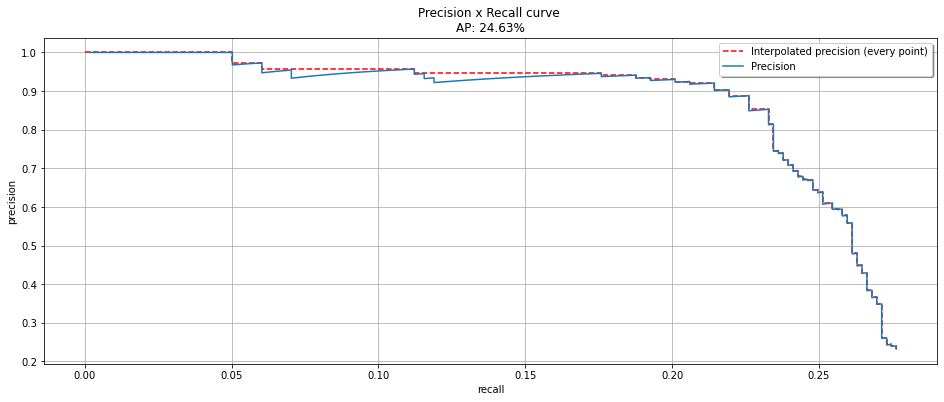

In [150]:
PlotPrecisionRecallCurve(r)

## Model 2 with learning RPN

In [31]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, RegionProposalNetwork

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 2  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # replace RegionProposalNetwork with a new one
# model.rpn = RegionProposalNetwork()
# model.eval()

In [32]:
model.roi_heads.box_predictor.cls_score.out_features

91

In [30]:
model.rpn.anchor_generator

AnchorGenerator()

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = WiderDataset(wider_img_list, wider_bboxes)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [ ]:
# output = model(images,targets)   # Returns losses and detections

In [ ]:
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

### Evaluation


In [20]:
def bbox_overlaps(boxes, query_boxes):
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    
    overlaps = np.zeros((N, K), dtype=np.float)
    box_areas = (query_boxes[:, 3] - query_boxes[:, 1]) * (query_boxes[:, 2] - query_boxes[:, 0])
    for k in range(K):
        box_area = box_areas[k]
        for n in range(N):
            iw = min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1

            if iw > 0:
                ih = min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1
                if ih > 0:
                    ua = (boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1) + box_area - iw * ih
                    overlaps[n, k] = iw * ih / ua
    
    return overlaps

In [107]:
def image_eval(pred, gt, iou_thresh):
    """ single image evaluation
    pred: Nx5
    gt: Nx4
    """

    _pred = pred['boxes'].numpy()
    _scores = pred['scores'].numpy()
    
    idx_sorted = np.argsort(_scores)[::-1]
    _pred = _pred[idx_sorted]
    _scores = _scores[idx_sorted]
    
    _gt = gt['boxes'].numpy()
    
    pred_recall = np.zeros(_pred.shape[0])
    TP = np.zeros(_pred.shape[0])
    FP = np.zeros(_pred.shape[0])
    gt_list = np.zeros(_gt.shape[0])

    overlaps = bbox_overlaps(_pred, _gt)
    
    for h in range(_pred.shape[0]):
        
#         if _scores[h] < score_thresh: 
#             continue
        
        gt_overlap = overlaps[h]
        max_overlap, max_idx = gt_overlap.max(), gt_overlap.argmax()
        if max_overlap >= iou_thresh and gt_list[max_idx] == 0:
            TP[h] = 1
            gt_list[max_idx] = 1
        else: FP[h] = 1
            
            
    return TP, FP, _scores


In [108]:
def CalculateAveragePrecision(rec, prec):
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(0)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    # return [ap, mpre[1:len(mpre)-1], mrec[1:len(mpre)-1], ii]
    return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

# @staticmethod
# 11-point interpolated average precision
def ElevenPointInterpolatedAP(rec, prec):
    # def CalculateAveragePrecision2(rec, prec):
    mrec = []
    # mrec.append(0)
    [mrec.append(e) for e in rec]
    # mrec.append(1)
    mpre = []
    # mpre.append(0)
    [mpre.append(e) for e in prec]
    # mpre.append(0)
    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp = []
    recallValid = []
    # For each recallValues (0, 0.1, 0.2, ... , 1)
    for r in recallValues:
        # Obtain all recall values higher or equal than r
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0
        # If there are recalls above r
        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])
        recallValid.append(r)
        rhoInterp.append(pmax)
    # By definition AP = sum(max(precision whose recall is above r))/11
    ap = sum(rhoInterp) / 11
    # Generating values for the plot
    rvals = []
    rvals.append(recallValid[0])
    [rvals.append(e) for e in recallValid]
    rvals.append(0)
    pvals = []
    pvals.append(0)
    [pvals.append(e) for e in rhoInterp]
    pvals.append(0)
    # rhoInterp = rhoInterp[::-1]
    cc = []
    for i in range(len(rvals)):
        p = (rvals[i], pvals[i - 1])
        if p not in cc:
            cc.append(p)
        p = (rvals[i], pvals[i])
        if p not in cc:
            cc.append(p)
    recallValues = [i[0] for i in cc]
    rhoInterp = [i[1] for i in cc]
    return [ap, rhoInterp, recallValues, None]


In [117]:
def evaluation(pred, gt_box, iou_thresh=0.3, interpolation_method = 'ElevenPoint'):
#     pred = get_preds(pred)
#     norm_score(pred)
    thresh_num = 1000
    aps = []
    TP_info = []
    FP_info = []
    scores_info = []
    # different setting
    count_face = 0
    pr_curve = np.zeros((thresh_num, 2)).astype('float')
    # [hard, medium, easy]
    pbar = tqdm.tqdm(range(len(pred)))
    for i in pbar:
        pbar.set_description('Processing ')
#             pred_list = pred
#             sub_gt_list = gt_list[i][0]
#             # img_pr_info_list = np.zeros((len(img_list), thresh_num, 2))
#             gt_bbx_list = facebox_list[i][0]

#             for j in range(len(img_list)):

        pred_info = pred[i]

        gt_boxes = gt_box[i]

        if len(gt_boxes) == 0 or len(pred_info) == 0:
            continue
        
        count_face += len(gt_boxes['boxes'])

        eval_results = image_eval(pred_info, gt_boxes, iou_thresh)
        
        
        TP_info.append(eval_results[0].copy())
        FP_info.append(eval_results[1].copy())
        
        scores_info.append(eval_results[2].copy())
        
    TP_info = np.array(list(itertools.chain(*TP_info)))
    FP_info = np.array(list(itertools.chain(*FP_info)))
    scores_info = np.array(list(itertools.chain(*scores_info)))
    
    scores_sorted_idx = np.argsort(scores_info)[::-1]
    TP_info = TP_info[scores_sorted_idx]
    FP_info = FP_info[scores_sorted_idx]
    scores_info = scores_info[scores_sorted_idx]
    
    acc_FP = np.cumsum(FP_info)
    acc_TP = np.cumsum(TP_info)
    rec = acc_TP / count_face
#     print(count_face)
    prec = np.divide(acc_TP, (acc_FP + acc_TP))
    
    if interpolation_method == 'ElevenPoint':
        [ap, mpre, mrec, ii] = ElevenPointInterpolatedAP(rec, prec)
    else: 
        [ap, mpre, mrec, ii] = CalculateAveragePrecision(rec, prec)
    
    r = {
            'precision': prec,
            'recall': rec,
            'AP': ap,
            'interpolated precision': mpre,
            'interpolated recall': mrec,
            'total positives': count_face,
            'total TP': np.sum(TP_info),
            'total FP': np.sum(FP_info)
        }

    return r


In [159]:
target_boxes = [x['boxes'] for x in targets]

In [177]:
pred = prediction
gt_box = targets
iou_thresh=0.2
score_thresh = 0.4

In [221]:
norm_score(pred)
thresh_num = 10
aps = []
TP_info = []
FP_info = []
scores_info = []
count_face = 0
pr_curve = np.zeros((thresh_num, 2)).astype('float')

In [230]:
# pbar = tqdm.tqdm(range(len(pred)))
# for i in pbar:
i=2
# pbar.set_description('Processing ')

pred_info = pred[i]

gt_boxes = gt_box[i]
# pred_info, gt_boxes

In [231]:
count_face += len(gt_boxes['boxes'])

# if len(gt_boxes) == 0 or len(pred_info) == 0:
#     continue

In [232]:
eval_results = image_eval(pred_info, gt_boxes, iou_thresh, score_thresh)

In [233]:
TP_info.append(eval_results[0])
FP_info.append(eval_results[1])
scores_info.append(eval_results[2])
np.array(list(itertools.chain(*scores_info)))

In [240]:
TP_info[0].sum(), TP_info[1].sum(), TP_info[2].sum()

(15.0, 32.0, 1.0)

In [257]:
TP_info = np.array(list(itertools.chain(*TP_info)))
FP_info = np.array(list(itertools.chain(*FP_info)))
scores_info = np.array(list(itertools.chain(*scores_info)))

In [258]:
scores_sorted_idx = np.argsort(scores_info)[::-1]
TP_info = TP_info[scores_sorted_idx]
FP_info = TP_info[scores_sorted_idx]
scores_info = scores_info[scores_sorted_idx]

In [259]:
count_face

53

In [260]:
acc_FP = np.cumsum(FP_info)
acc_TP = np.cumsum(TP_info)
rec = acc_TP / count_face
prec = np.divide(acc_TP, (acc_FP + acc_TP))

In [261]:
# a = CalculateAveragePrecision(rec, prec)